# Prediction Model in GST (EDA)

```python

# To install the lib's uncomment the line below

%pip install

```

In [1]:
# %pip install numpy tensorflow matplotlib pandas scikit-learn seaborn imblearn shap

## Importing the required libraries

In [2]:
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (confusion_matrix)
from tensorflow.keras import mixed_precision  # type: ignore
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping  # type: ignore
from tensorflow.keras.layers import (BatchNormalization, Dense,  # type: ignore
                                     Dropout, Flatten, Input, PReLU)
from tensorflow.keras.models import Model  # type: ignore
from tensorflow.keras.initializers import HeNormal  # type: ignore  
from tensorflow.keras.optimizers import Adam  # type: ignore
from tensorflow.keras.utils import to_categorical  # type: ignore

In [3]:
%matplotlib inline

## This will ignore the user warnings given by tensorflow

In [4]:
import warnings as w

w.filterwarnings("ignore", category=FutureWarning)

## To set the precision policy to **_mixedfloat16_**

In [5]:
policy = mixed_precision.Policy("mixed_float16")

mixed_precision.set_global_policy(policy)

print("Compute dtype: %s" % policy.compute_dtype)

Compute dtype: float16


## Creating a floder to collect the data genrated by the model for analysis

In [6]:
dir = 'info'

if not os.path.exists(dir):
    os.makedirs(dir)
    print(f"Directory {dir} created ")

##  Data Loading

In [7]:
# path of the dataset

data_dir = 'data'

X_train_path = os.path.join(data_dir, 'X_Train_Data_Input.csv')

X_test_path = os.path.join(data_dir, 'X_Test_Data_Input.csv')

Y_train_path = os.path.join(data_dir, 'Y_Train_Data_Target.csv')

Y_test_path = os.path.join(data_dir, 'Y_Test_Data_Target.csv')

print(f"Filenames: {X_train_path}, {X_test_path}, {Y_train_path}, {Y_test_path}")

Filenames: data\X_Train_Data_Input.csv, data\X_Test_Data_Input.csv, data\Y_Train_Data_Target.csv, data\Y_Test_Data_Target.csv


In [8]:
# Loading the training dataset
X_train = pd.read_csv(X_train_path)
Y_train = pd.read_csv(Y_train_path)

# Loading the validation dataset
X_test = pd.read_csv(X_test_path)
Y_test = pd.read_csv(Y_test_path)

print(f'The dataset has been loaded successfully at {data_dir}')

The dataset has been loaded successfully at data


## Creating a copy of the datasets for data cleaning and processing 

In [9]:
# Copying training dataset
X_train = X_train.copy()
Y_train = Y_train.copy()

# Copying validation dataset
X_test = X_test.copy()
Y_test = Y_test.copy()

print(f'The dataset has been copied successfully')

The dataset has been copied successfully


In [10]:
X_train.head()

,ID,Column0,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,...,Column12,Column13,Column14,Column15,Column16,Column17,Column18,Column19,Column20,Column21
0,ad1a67e4cbddc767a3456b0d94299b9e,2.0,2495,3726.0,0.678139,0.701403,-0.007468,0.434190,-0.015603,0.606265,...,0,0,0.001351,0.00339,0.0,0,0.0,0,0,0
1,7246d2f76ac0c217ec25e72ea5f014cb,0.0,2495,3454.0,0.452580,0.701403,-0.007468,1.554998,-0.015574,0.329946,...,0,0,0.001351,0.00339,0.0,0,0.0,0,0,0
2,22ba388e7dd14c13342c49e75fc29dda,2.0,2495,4543.0,-1.577453,-1.429540,-0.007469,-0.407939,-0.015607,-0.774979,...,1,1,0.001351,0.00339,0.0,0,0.0,0,0,0
3,59f9b981472d97342587fb3e6392aeb1,0.0,211,59.0,NaN,NaN,NaN,-0.407939,-0.015607,-0.774979,...,0,0,NaN,0.00339,0.0,0,1.0,0,0,0
4,f6317cf7ecf126859804eddff279aead,0.0,718,950.0,-2.028572,-1.855728,NaN,-0.407939,-0.015607,-0.774979,...,0,0,NaN,0.00339,0.0,0,0.0,0,0,0


In [11]:
X_test.head()

,ID,Column0,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,...,Column12,Column13,Column14,Column15,Column16,Column17,Column18,Column19,Column20,Column21
0,07cf2025382f6325b316e128b1b90999,1.0,1986,53.0,0.678139,0.701403,-0.007469,-0.407939,-0.015607,0.554860,...,1,1,0.001351,0.00339,0.0,0,0.0,0,0,0
1,eb972eb3a1f8d0d1a13f45e7c07d37d4,2.0,1579,12.0,0.678139,0.701403,-0.007468,-0.407939,-0.015607,0.142149,...,1,0,0.001351,0.00339,0.0,0,0.0,0,0,0
2,ee35e164b3ddc25a9f40243b81ad290d,0.0,898,3817.0,-2.028572,-1.855728,NaN,-0.407939,-0.015607,-0.774979,...,0,0,NaN,0.00339,0.0,0,0.0,0,0,0
3,28229ccd7bad7dd83324a4175a7e0531,0.0,79,3449.0,-0.675216,-0.577162,-0.007469,0.004020,-0.015607,0.635264,...,0,1,0.001351,0.00339,0.0,0,0.0,0,0,0
4,2f94873da2c332d28f111742818e0fbb,1.0,646,6510.0,-2.028572,-1.855728,NaN,-0.407939,-0.015434,-0.774979,...,1,1,NaN,0.00339,0.0,0,0.0,0,0,0


In [12]:
X_train.shape, X_test.shape

((785133, 23), (261712, 23))

- **Here we can see that the training dataset contains 785133 samples and the validation dataset contains 261712 samples**

In [13]:
print(f'The training dataset has {X_train.shape[0]} rows and {X_train.shape[1]} columns were as the validation dataset has {X_test.shape[0]} rows and {X_test.shape[1]} columns')

The training dataset has 785133 rows and 23 columns were as the validation dataset has 261712 rows and 23 columns


In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785133 entries, 0 to 785132
Data columns (total 23 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ID        785133 non-null  object 
 1   Column0   785124 non-null  float64
 2   Column1   785133 non-null  int64  
 3   Column2   785133 non-null  float64
 4   Column3   658830 non-null  float64
 5   Column4   657423 non-null  float64
 6   Column5   617953 non-null  float64
 7   Column6   781283 non-null  float64
 8   Column7   785133 non-null  float64
 9   Column8   781283 non-null  float64
 10  Column9   52996 non-null   float64
 11  Column10  785133 non-null  int64  
 12  Column11  785133 non-null  int64  
 13  Column12  785133 non-null  int64  
 14  Column13  785133 non-null  int64  
 15  Column14  419430 non-null  float64
 16  Column15  768677 non-null  float64
 17  Column16  785133 non-null  float64
 18  Column17  785133 non-null  int64  
 19  Column18  785133 non-null  float64
 20  Colu

In [15]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261712 entries, 0 to 261711
Data columns (total 23 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ID        261712 non-null  object 
 1   Column0   261710 non-null  float64
 2   Column1   261712 non-null  int64  
 3   Column2   261712 non-null  float64
 4   Column3   219478 non-null  float64
 5   Column4   219002 non-null  float64
 6   Column5   206053 non-null  float64
 7   Column6   260478 non-null  float64
 8   Column7   261712 non-null  float64
 9   Column8   260478 non-null  float64
 10  Column9   17859 non-null   float64
 11  Column10  261712 non-null  int64  
 12  Column11  261712 non-null  int64  
 13  Column12  261712 non-null  int64  
 14  Column13  261712 non-null  int64  
 15  Column14  140033 non-null  float64
 16  Column15  256227 non-null  float64
 17  Column16  261712 non-null  float64
 18  Column17  261712 non-null  int64  
 19  Column18  261712 non-null  float64
 20  Colu

In [16]:
X_train.dtypes

ID           object
Column0     float64
Column1       int64
Column2     float64
Column3     float64
Column4     float64
Column5     float64
Column6     float64
Column7     float64
Column8     float64
Column9     float64
Column10      int64
Column11      int64
Column12      int64
Column13      int64
Column14    float64
Column15    float64
Column16    float64
Column17      int64
Column18    float64
Column19      int64
Column20      int64
Column21      int64
dtype: object

In [17]:
X_test.dtypes

ID           object
Column0     float64
Column1       int64
Column2     float64
Column3     float64
Column4     float64
Column5     float64
Column6     float64
Column7     float64
Column8     float64
Column9     float64
Column10      int64
Column11      int64
Column12      int64
Column13      int64
Column14    float64
Column15    float64
Column16    float64
Column17      int64
Column18    float64
Column19      int64
Column20      int64
Column21      int64
dtype: object

In [18]:
X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Column0,785124.0,0.440757,1.163275,0.000000,0.000000,0.000000,0.000000,18.000000
Column1,785133.0,1321.788614,907.267965,-1080.000000,515.000000,1173.000000,2435.000000,2499.000000
Column2,785133.0,2951.279411,2143.140140,-47.000000,1129.000000,2709.000000,4472.000000,10290.000000
Column3,658830.0,-0.000210,0.999935,-2.028572,-0.675216,0.678139,0.678139,0.678139
Column4,657423.0,-0.000855,1.000350,-1.855728,-0.577162,0.701403,0.701403,0.701403
Column5,617953.0,-0.000367,1.015255,-0.007469,-0.007469,-0.007469,-0.007468,551.421127
Column6,781283.0,-0.000709,0.998984,-0.407939,-0.407939,-0.407939,-0.367723,14.985817
Column7,785133.0,0.000727,1.045883,-0.015607,-0.015607,-0.015607,-0.015607,201.687947
Column8,781283.0,-0.000158,1.056769,-0.774979,-0.774979,0.122085,0.625528,323.992484
Column9,52996.0,0.005245,1.111058,-0.088554,-0.086503,-0.081820,-0.063140,133.911803


In [19]:
X_test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Column0,261710.0,0.441684,1.168206,0.000000,0.000000,0.000000,0.000000,18.000000
Column1,261712.0,1321.450530,908.290073,-933.000000,513.000000,1173.000000,2436.000000,2501.000000
Column2,261712.0,2956.365153,2147.398218,-57.000000,1131.000000,2716.000000,4478.000000,9977.000000
Column3,219478.0,0.001422,0.999297,-2.028572,-0.675216,0.678139,0.678139,0.678139
Column4,219002.0,0.002494,0.998968,-1.855728,-0.577162,0.701403,0.701403,0.701403
Column5,206053.0,0.000998,1.194067,-0.007469,-0.007469,-0.007469,-0.007468,357.204763
Column6,260478.0,0.003269,1.003476,-0.407939,-0.407939,-0.407939,-0.363713,3.440527
Column7,261712.0,-0.000461,0.957254,-0.015607,-0.015607,-0.015607,-0.015607,187.807115
Column8,260478.0,0.000477,0.897452,-0.774979,-0.774979,0.127514,0.627312,120.465103
Column9,17859.0,-0.008717,0.807577,-0.088554,-0.086591,-0.081951,-0.063544,51.780491


## Data Processing

In [20]:
X_train_cols = X_train.columns

X_test_cols = X_test.columns

In [21]:
X_train_cols

Index(['ID', 'Column0', 'Column1', 'Column2', 'Column3', 'Column4', 'Column5',
       'Column6', 'Column7', 'Column8', 'Column9', 'Column10', 'Column11',
       'Column12', 'Column13', 'Column14', 'Column15', 'Column16', 'Column17',
       'Column18', 'Column19', 'Column20', 'Column21'],
      dtype='object')

In [22]:
X_test_cols

Index(['ID', 'Column0', 'Column1', 'Column2', 'Column3', 'Column4', 'Column5',
       'Column6', 'Column7', 'Column8', 'Column9', 'Column10', 'Column11',
       'Column12', 'Column13', 'Column14', 'Column15', 'Column16', 'Column17',
       'Column18', 'Column19', 'Column20', 'Column21'],
      dtype='object')

In [23]:
# Creating the folder to save the null values plot in info folder

null_values = 'null_values'

null_values_path = os.path.join(dir, null_values)

if not os.path.exists(null_values_path):
    os.makedirs(null_values_path)
    print(f"Directory {null_values_path} created ")

In [24]:
# Checking for missing values in the training dataset and validation dataset

X_train_empty = X_train.isnull().sum()

X_test_empty = X_test.isnull().sum()

In [25]:
X_train_empty

ID               0
Column0          9
Column1          0
Column2          0
Column3     126303
Column4     127710
Column5     167180
Column6       3850
Column7          0
Column8       3850
Column9     732137
Column10         0
Column11         0
Column12         0
Column13         0
Column14    365703
Column15     16456
Column16         0
Column17         0
Column18         0
Column19         0
Column20         0
Column21         0
dtype: int64

The plot is saved successfully at info\null_values


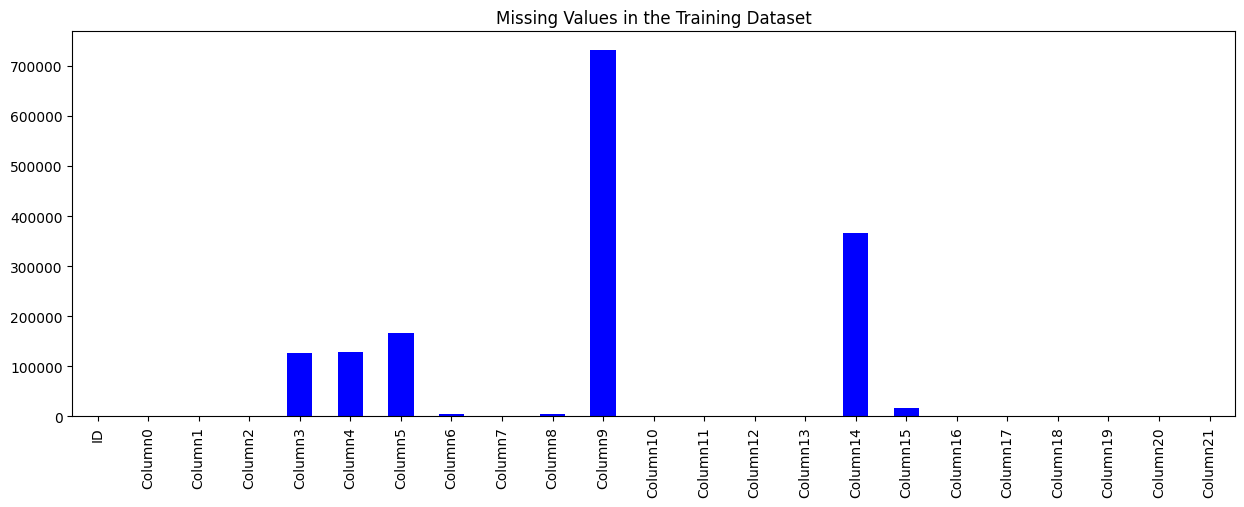

In [26]:
# Ploting the missing values in the training dataset

X_train_empty.plot(kind='bar', figsize=(15, 5), color='blue', title='Missing Values in the Training Dataset')

plt.savefig(os.path.join(null_values_path, 'X_train_missing_values.png'))

print(f'The plot is saved successfully at {null_values_path}')

In [27]:
X_test_empty

ID               0
Column0          2
Column1          0
Column2          0
Column3      42234
Column4      42710
Column5      55659
Column6       1234
Column7          0
Column8       1234
Column9     243853
Column10         0
Column11         0
Column12         0
Column13         0
Column14    121679
Column15      5485
Column16         0
Column17         0
Column18         0
Column19         0
Column20         0
Column21         0
dtype: int64

The plot is saved successfully at info\null_values


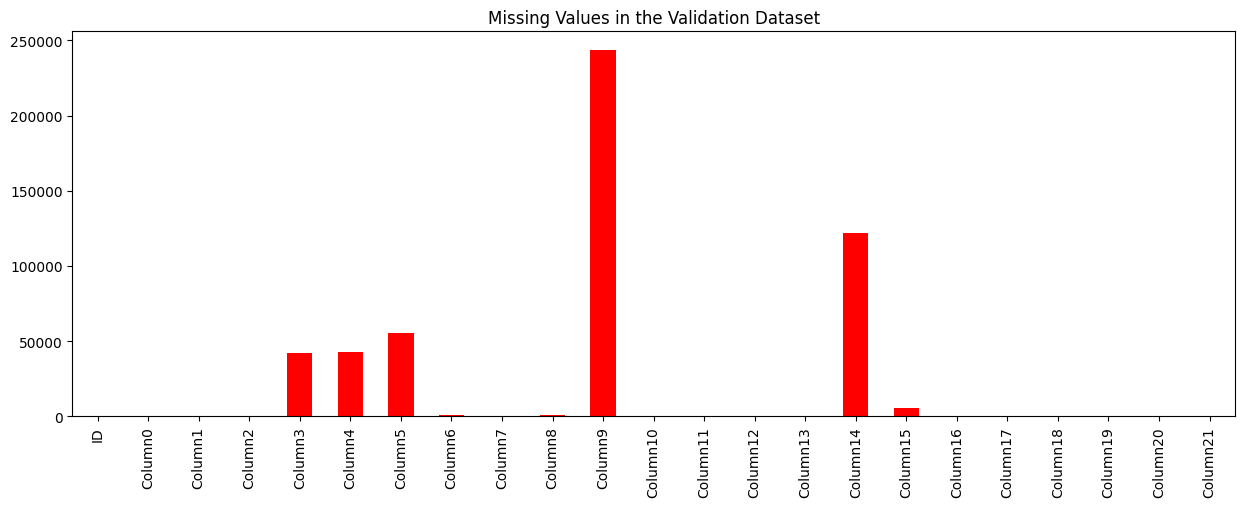

In [28]:
# Ploting the missing values in the validation dataset

X_test_empty.plot(kind='bar', figsize=(15, 5), color='red', title='Missing Values in the Validation Dataset')

plt.savefig(os.path.join(null_values_path, 'X_test_missing_values.png'))

print(f'The plot is saved successfully at {null_values_path}')

- **We will drop both the ID, and Column9 from both the datasets as in Column9 most values are empty and the ID column will not be usefull for training**

In [29]:
print(f'The Column9 in the training dataset has {round((X_train_empty.iloc[10] / X_train.shape[0])*100)}% missing values and the Column9 in the validation dataset has {round((X_test_empty.iloc[10] / X_test.shape[0])*100)}% missing values')

The Column9 in the training dataset has 93% missing values and the Column9 in the validation dataset has 93% missing values


In [30]:
# Dropping the missing values and Column9 in the training dataset
X_train.drop(columns=['Column9', 'ID'], inplace=True)
Y_train.drop(columns=['ID'], inplace=True)

# Dropping the missing values and Column9 in the validation dataset
X_test.drop(columns=['Column9', 'ID'], inplace=True)
Y_test.drop(columns=['ID'], inplace=True)

In [31]:
X_train_cols = X_train.columns

X_test_cols = X_test.columns

In [32]:
X_train_cols

Index(['Column0', 'Column1', 'Column2', 'Column3', 'Column4', 'Column5',
       'Column6', 'Column7', 'Column8', 'Column10', 'Column11', 'Column12',
       'Column13', 'Column14', 'Column15', 'Column16', 'Column17', 'Column18',
       'Column19', 'Column20', 'Column21'],
      dtype='object')

In [33]:
X_test_cols

Index(['Column0', 'Column1', 'Column2', 'Column3', 'Column4', 'Column5',
       'Column6', 'Column7', 'Column8', 'Column10', 'Column11', 'Column12',
       'Column13', 'Column14', 'Column15', 'Column16', 'Column17', 'Column18',
       'Column19', 'Column20', 'Column21'],
      dtype='object')

**Filling the empty col values with mode as its common practice here**

In [34]:
# Filling the missing values in the training dataset and validation dataset using Simple Imputer

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train_cols)

X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test_cols)

In [35]:
# Checking for missing values in the training dataset and validation dataset

X_train_empty = X_train.isnull().sum()

X_test_empty = X_test.isnull().sum()

In [36]:
X_train_empty

Column0     0
Column1     0
Column2     0
Column3     0
Column4     0
Column5     0
Column6     0
Column7     0
Column8     0
Column10    0
Column11    0
Column12    0
Column13    0
Column14    0
Column15    0
Column16    0
Column17    0
Column18    0
Column19    0
Column20    0
Column21    0
dtype: int64

In [37]:
X_test_empty

Column0     0
Column1     0
Column2     0
Column3     0
Column4     0
Column5     0
Column6     0
Column7     0
Column8     0
Column10    0
Column11    0
Column12    0
Column13    0
Column14    0
Column15    0
Column16    0
Column17    0
Column18    0
Column19    0
Column20    0
Column21    0
dtype: int64

**Checking the Correlation of features with the target variable**

In [38]:
# Creating the folder to save the Correlation value plot in info folder

correlation = 'correlation'

correlation_path = os.path.join(dir, correlation)

if not os.path.exists(correlation_path):
    os.makedirs(correlation_path)
    print(f"Directory {correlation_path} created ")

The plot is saved successfully at info\correlation


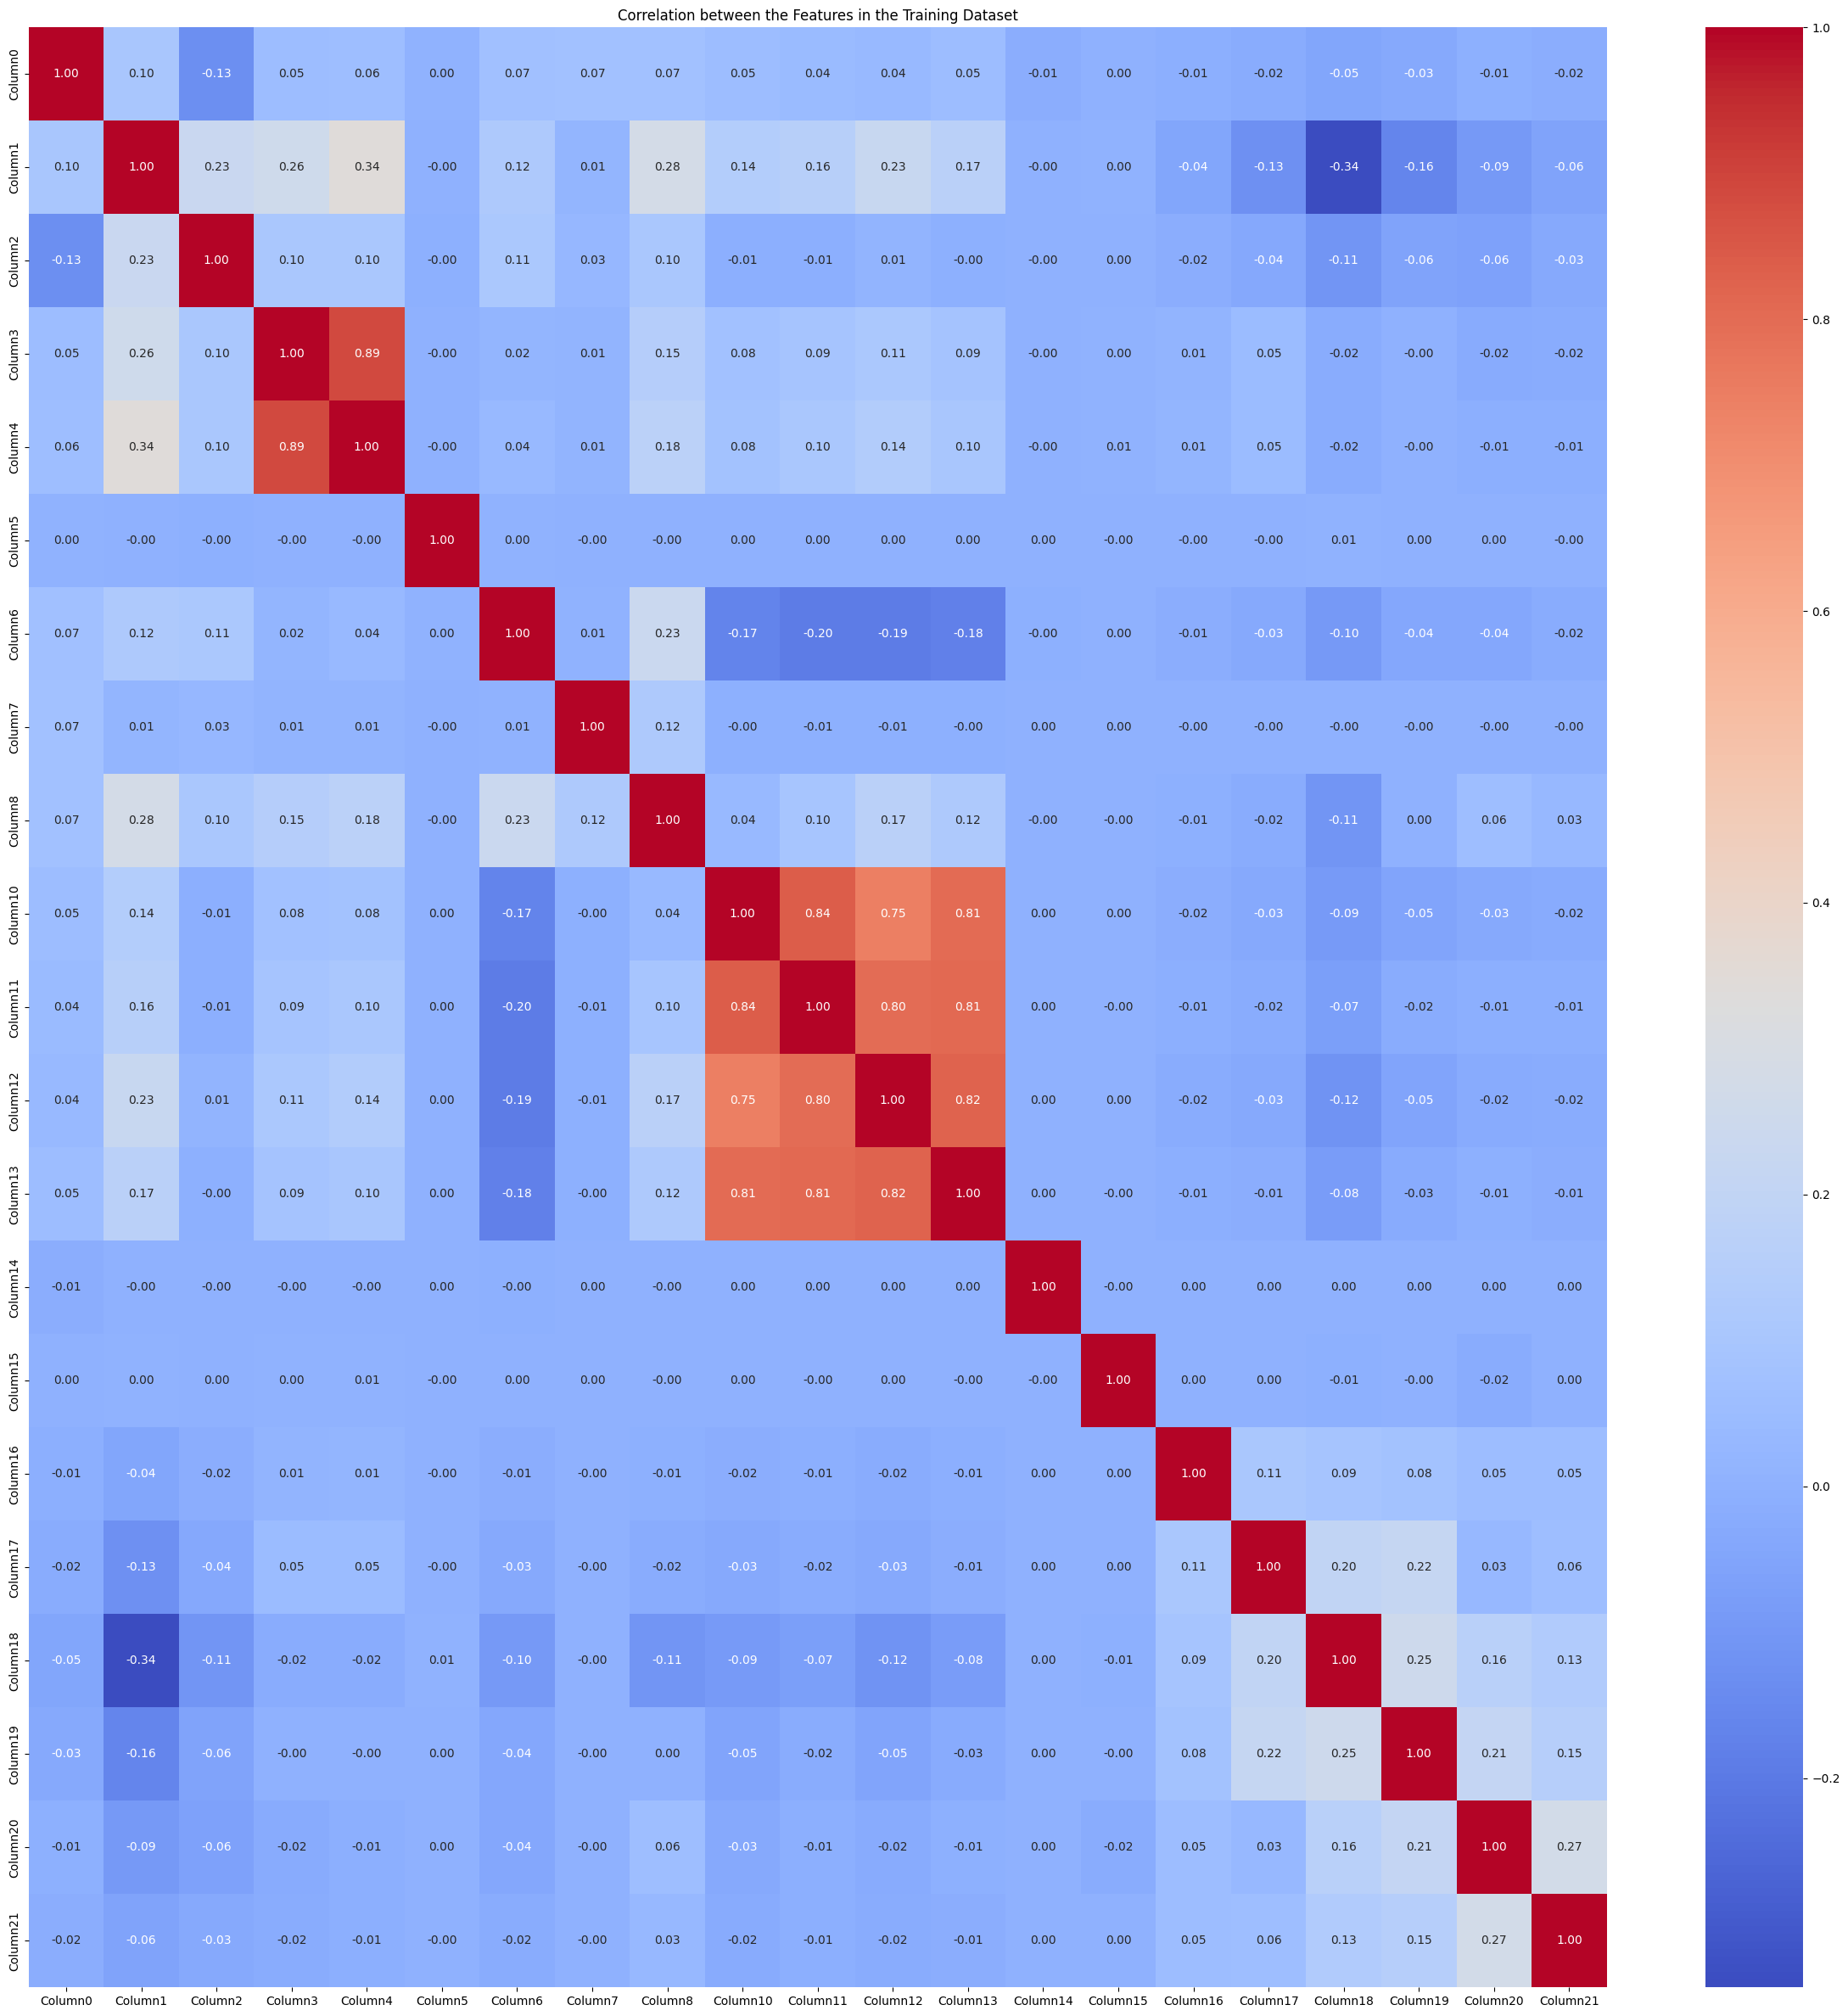

In [39]:
# Checking the correlation between the features in the training dataset

plt.figure(figsize=(30, 30))

sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm', fmt='.2f')

plt.title('Correlation between the Features in the Training Dataset')

plt.savefig(os.path.join(correlation_path, 'X_train_correlation.png'))

print(f'The plot is saved successfully at {correlation_path}')

The plot is save successfully at info\correlation


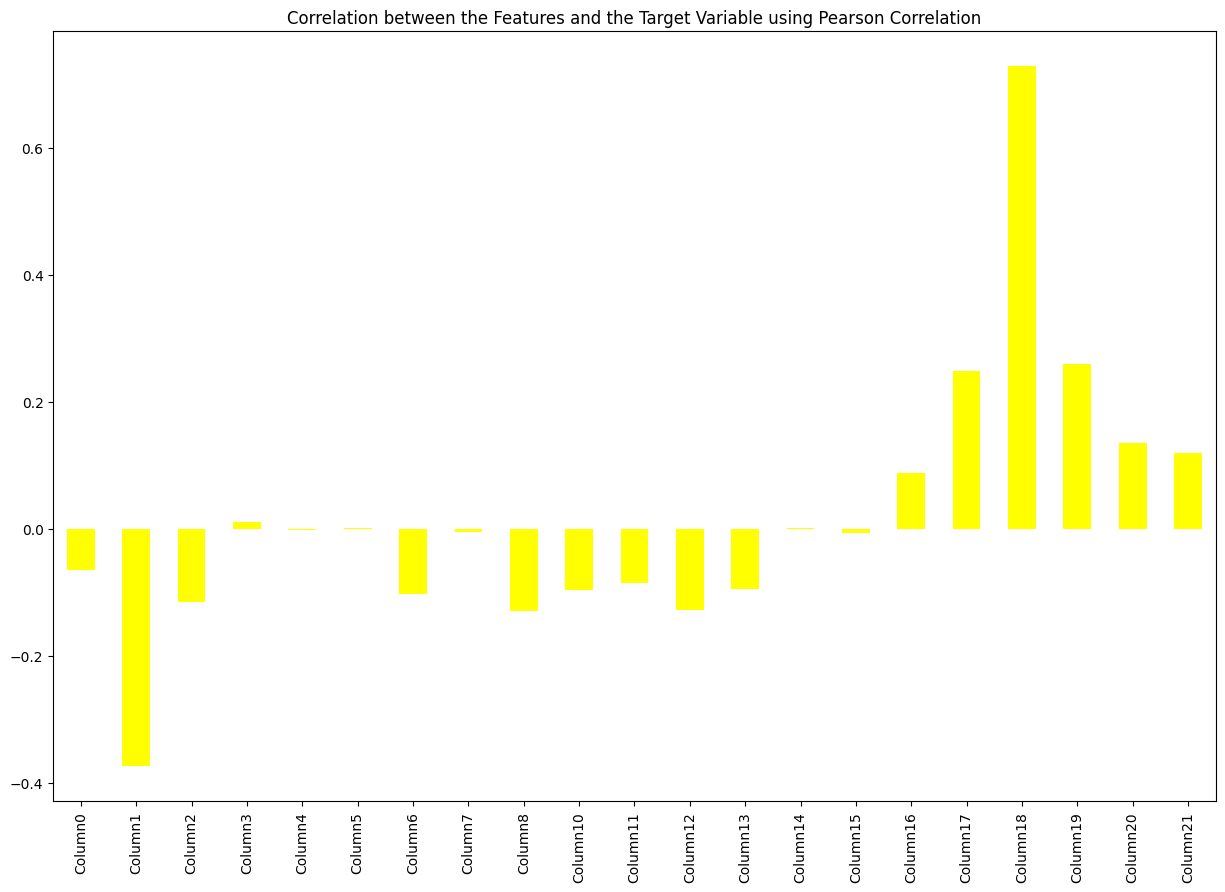

In [40]:
# Using the Pearson correlation to check for the correlation between the features and the target variable

correlation = X_train.corrwith(Y_train['target'], method='pearson')

# Plotting the correlation between the features and the target variable

correlation.plot(kind='bar', figsize=(15, 10), color='yellow', title='Correlation between the Features and the Target Variable')

plt.savefig(os.path.join(correlation_path, 'X_train_correlation_target.png'))

plt.title('Correlation between the Features and the Target Variable using Pearson Correlation')

print(f'The plot is save successfully at {correlation_path}')

In [41]:
print(f'This helps us to know the which features are highly correlated with the target variable. It checks for the linear relationship between the features and the target variable')

This helps us to know the which features are highly correlated with the target variable. It checks for the linear relationship between the features and the target variable


The plot is save successfully at info\correlation


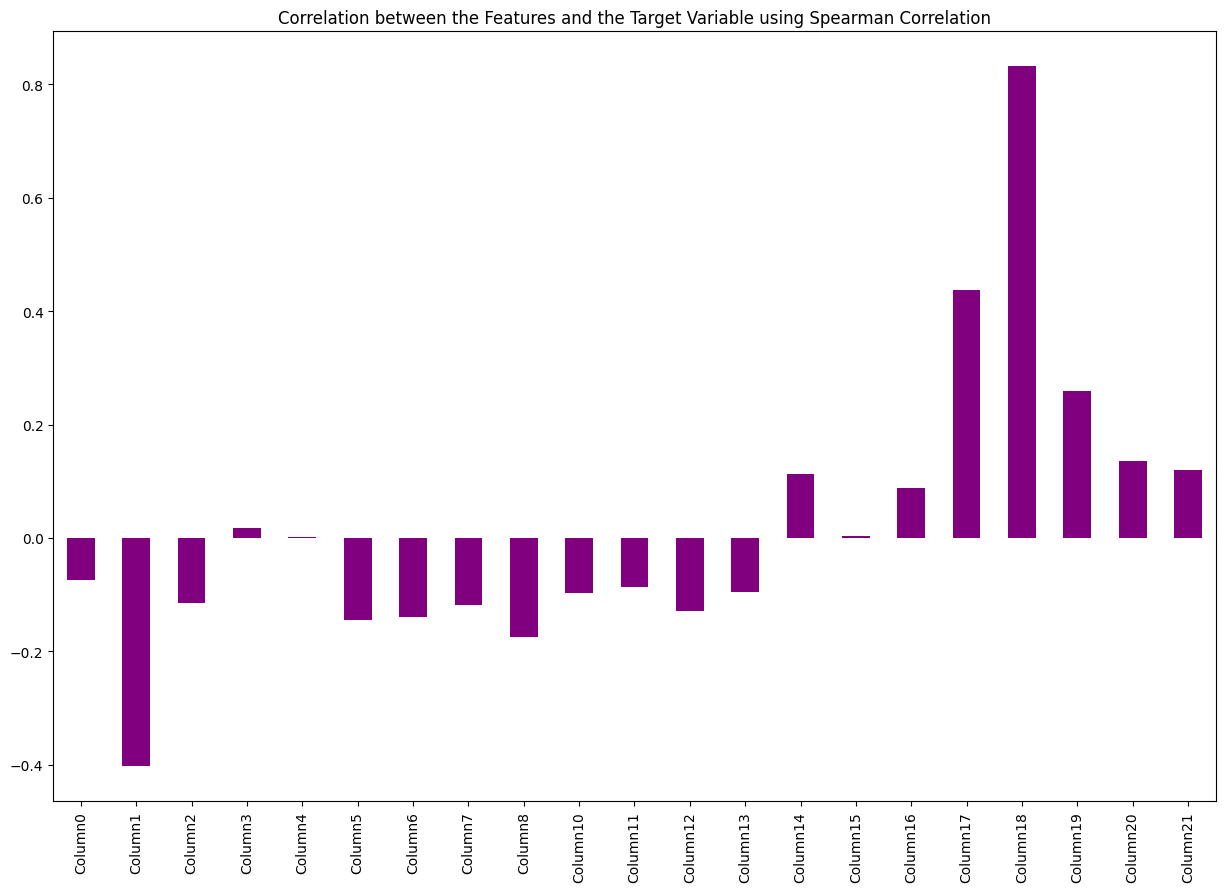

In [42]:
# Using the Spearman correlation to check for the correlation between the features and the target variable

correlation = X_train.corrwith(Y_train['target'], method='spearman')

# Plotting the correlation between the features and the target variable

correlation.plot(kind='bar', figsize=(15, 10), color='purple', title='Correlation between the Features and the Target Variable using Spearman Correlation')

plt.savefig(os.path.join(correlation_path, 'X_train_correlation_target_spearman.png'))

print(f'The plot is save successfully at {correlation_path}')

In [43]:
print(f'This helps us to know the which features are highly correlated with the target variable. It checks for the non-linear relationship between the features and the target variable')

This helps us to know the which features are highly correlated with the target variable. It checks for the non-linear relationship between the features and the target variable


The plot is save successfully at info\correlation


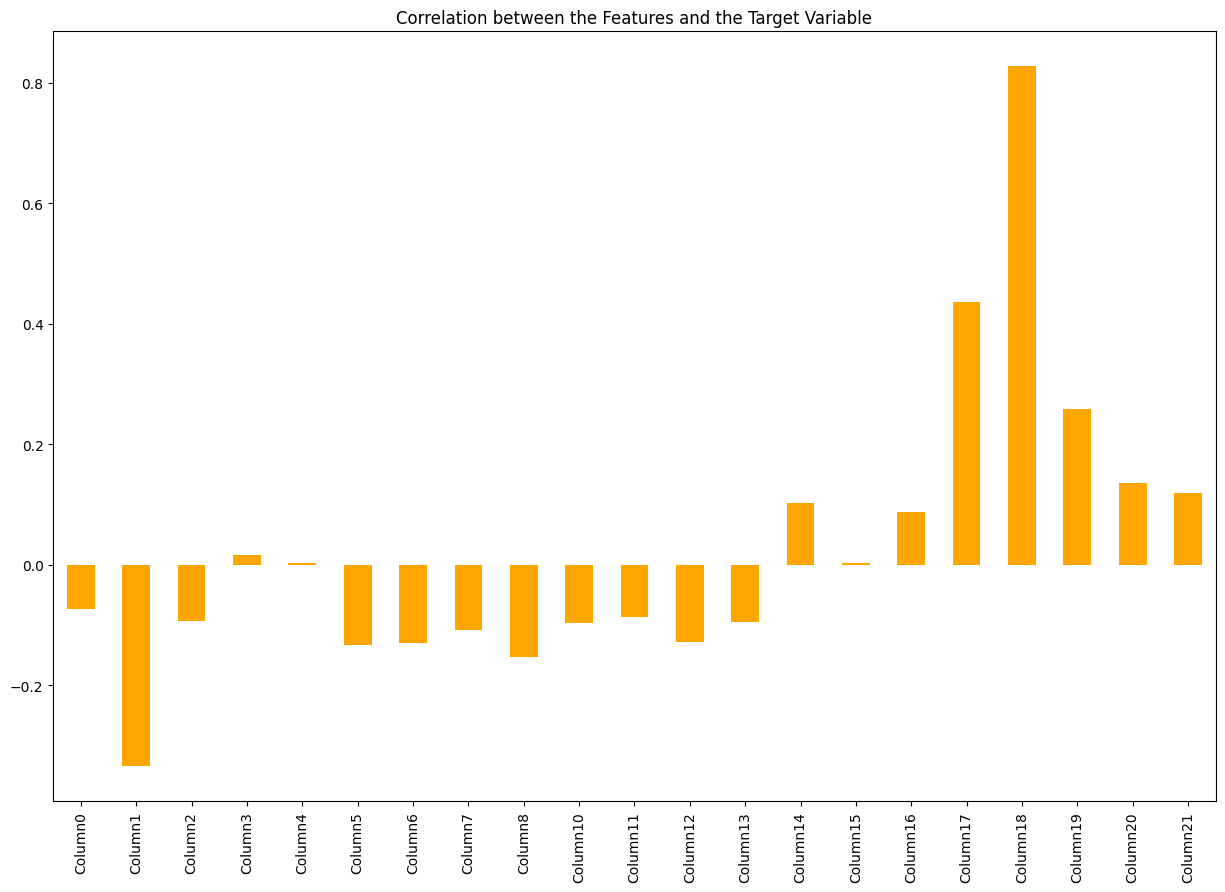

In [44]:
# Using the Kendall correlation to check for the correlation between the features and the target variable

correlation = X_train.corrwith(Y_train['target'], method='kendall')

# Plotting the correlation between the features and the target variable

correlation.plot(kind='bar', figsize=(15, 10), color='orange', title='Correlation between the Features and the Target Variable')

plt.savefig(os.path.join(correlation_path, 'X_train_correlation_target_kendall.png'))

print(f'The plot is save successfully at {correlation_path}')

In [45]:
print(f'This helps us to know the which features are highly correlated with the target variable. It checks for the non-linear relationship between the features and the target variable')

This helps us to know the which features are highly correlated with the target variable. It checks for the non-linear relationship between the features and the target variable


In [46]:
X_train_cols = X_train.columns

X_test_cols = X_test.columns

In [47]:
X_train_cols

Index(['Column0', 'Column1', 'Column2', 'Column3', 'Column4', 'Column5',
       'Column6', 'Column7', 'Column8', 'Column10', 'Column11', 'Column12',
       'Column13', 'Column14', 'Column15', 'Column16', 'Column17', 'Column18',
       'Column19', 'Column20', 'Column21'],
      dtype='object')

In [48]:
X_test_cols

Index(['Column0', 'Column1', 'Column2', 'Column3', 'Column4', 'Column5',
       'Column6', 'Column7', 'Column8', 'Column10', 'Column11', 'Column12',
       'Column13', 'Column14', 'Column15', 'Column16', 'Column17', 'Column18',
       'Column19', 'Column20', 'Column21'],
      dtype='object')

**Checking the balance of classes in dataset**

In [49]:
# Creating the folder to save the distribution values for classes in info folder

class_distribution = 'class_distribution'

class_distribution_path = os.path.join(dir, class_distribution)

if not os.path.exists(class_distribution_path):
    os.makedirs(class_distribution_path)
    print(f"Directory {class_distribution_path} created ")

The plot is saved successfully at info\class_distribution


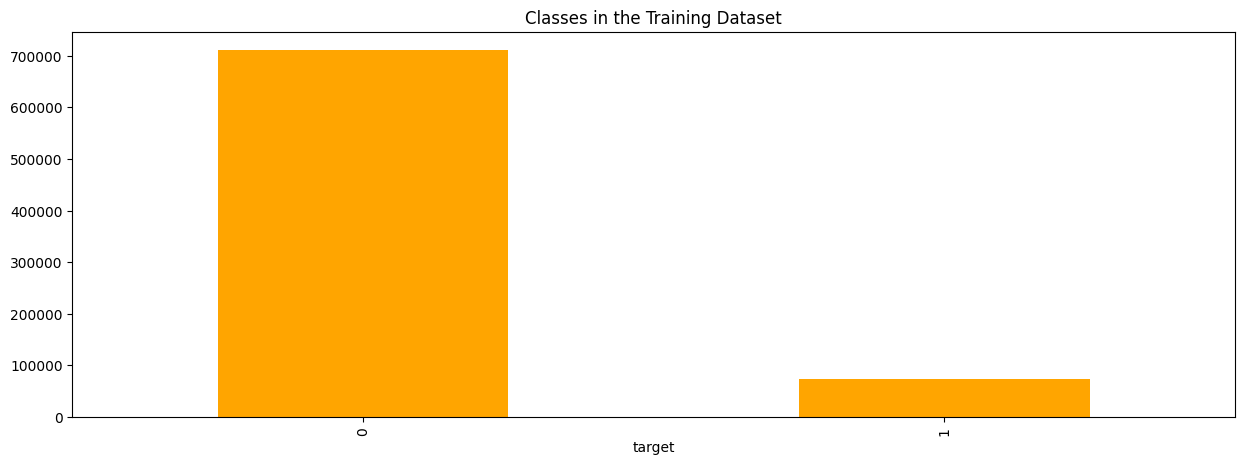

In [50]:
# Ploting the classes in the training dataset

classCount = Y_train['target'].value_counts()

classCount.plot(kind='bar', figsize=(15, 5), color='orange', title='Classes in the Training Dataset')

plt.savefig(os.path.join(class_distribution_path, 'Y_train_class_distribution.png'))

print(f'The plot is saved successfully at {class_distribution_path}')

**Using the SMOTE method to balance the classes**

In [ ]:
# Applying SMOTE to balance the classes in the training dataset

from imblearn.over_sampling import SMOTE

os.environ['LOCKY_MAX_CPU_COUNT'] = '6'
smote = SMOTE(sampling_strategy='minority' , random_state=42, k_neighbors=21)


X_train, Y_train = smote.fit_resample(X_train, Y_train)

<Axes: title={'center': 'Classes in the Training Dataset after applying SMOTE'}, xlabel='target'>

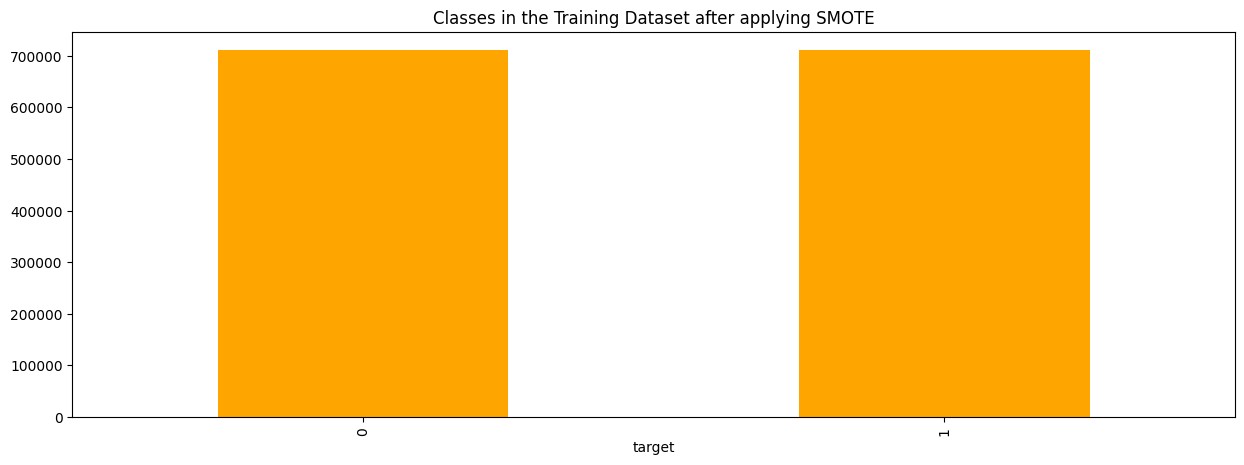

In [52]:
# Ploting the classes in the training dataset after applying SMOTE

classCount = Y_train['target'].value_counts()

classCount.plot(kind='bar', figsize=(15, 5), color='orange', title='Classes in the Training Dataset after applying SMOTE')

In [53]:
# Normalizing the training dataset and validation dataset using MinMaxScaler

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

# Rounding the values to just 6 decimal places

X_train = np.round(X_train, 6)

X_test = np.round(X_test, 6)

In [54]:
# Converting the training dataset and validation dataset to a DataFrame

X_train = pd.DataFrame(X_train, columns=X_train_cols)

X_test = pd.DataFrame(X_test, columns=X_test_cols)

In [55]:
# Converting the target variable to categorical

Y_train = to_categorical(Y_train)

Y_test = to_categorical(Y_test)

## A simple FCNN based model

In [56]:
# Learning Rate Scheduler

def scheduler(epoch, lr):
    if epoch < 1:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))
    
lr_scheduler = LearningRateScheduler(scheduler)

In [57]:
# Reduce Learning Rate on Plateau

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=0.0001)

In [58]:
# Early Stopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [59]:
# Optimizer 

opt = Adam(learning_rate=0.001)

In [60]:
# Dropout Rate

rate = 0.4

In [61]:
# activation function not as a layer

activation = None

In [62]:
# loss function

loss = 'binary_crossentropy'

In [63]:
# Weight Initialization

initializer = HeNormal()

In [64]:
# Model architecture 

input = Input(shape=(X_train.shape[1],))

x = Dense(64, activation=activation, kernel_initializer=initializer)(input)
x = PReLU()(x)
x = BatchNormalization()(x)
x = Dropout(rate)(x)


x = Dense(64, activation=activation, kernel_initializer=initializer)(x)
x = PReLU()(x)
x = BatchNormalization()(x)
x = Dropout(rate)(x)


x = Dense(64, activation=activation, kernel_initializer=initializer)(x)
x = PReLU()(x)
x = BatchNormalization()(x)
x = Dropout(rate)(x)


x = Flatten()(x)

output = Dense(2, activation='softmax')(x)

model = Model(inputs=input, outputs=output)

model.compile(optimizer=opt, loss=loss, metrics=['accuracy', 'precision', 'recall', 'auc', 'f1_score', 'mse'])

In [65]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu (PReLU)                 │ (None, 64)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_1 (PReLU)               │ (None, 64)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_2 (PReLU)               │ (None, 64)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,818 (42.26 KB)

 Trainable params: 10,434 (40.76 KB)

 Non-trainable params: 384 (1.50 KB)

In [66]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50, batch_size=64, callbacks=[lr_scheduler, reduce_lr, early_stopping])

Epoch 1/50
22222/22222 ━━━━━━━━━━━━━━━━━━━━ 128s 6ms/step - accuracy: 0.9513 - auc: 0.9817 - f1_score: 0.9513 - loss: 0.1410 - mse: 0.0382 - precision: 0.9513 - recall: 0.9513 - val_accuracy: 0.9652 - val_auc: 0.9972 - val_f1_score: 0.9122 - val_loss: 0.0895 - val_mse: 0.0268 - val_precision: 0.9652 - val_recall: 0.9652 - learning_rate: 0.0010
Epoch 2/50
22222/22222 ━━━━━━━━━━━━━━━━━━━━ 119s 5ms/step - accuracy: 0.9805 - auc: 0.9962 - f1_score: 0.9805 - loss: 0.0651 - mse: 0.0164 - precision: 0.9805 - recall: 0.9805 - val_accuracy: 0.9651 - val_auc: 0.9972 - val_f1_score: 0.9121 - val_loss: 0.0903 - val_mse: 0.0267 - val_precision: 0.9651 - val_recall: 0.9651 - learning_rate: 9.0484e-04
Epoch 3/50
22222/22222 ━━━━━━━━━━━━━━━━━━━━ 132s 6ms/step - accuracy: 0.9808 - auc: 0.9966 - f1_score: 0.9808 - loss: 0.0626 - mse: 0.0159 - precision: 0.9808 - recall: 0.9808 - val_accuracy: 0.9682 - val_auc: 0.9973 - val_f1_score: 0.9186 - val_loss: 0.0790 - val_mse: 0.0235 - val_precision: 0.9682 - v

In [67]:
# Creating the folder to save the model in info folder

model_folder = 'model'

model_folder_path = os.path.join(dir, model_folder)

if not os.path.exists(model_folder_path):
    os.makedirs(model_folder_path)
    print(f"Directory {model_folder_path} created ")

Directory info\model created 


In [68]:
# Saving the model

model.save(os.path.join(model_folder_path, 'GSTIN.keras'))

In [69]:
# Creating the folder to save the model accuracy and loss in info folder

model_accuracy_loss = 'model_accuracy_loss'

model_accuracy_loss_path = os.path.join(dir, model_accuracy_loss)

if not os.path.exists(model_accuracy_loss_path):
    os.makedirs(model_accuracy_loss_path)
    print(f"Directory {model_accuracy_loss_path} created ")

Directory info\model_accuracy_loss created 


The model accuracy and loss has been saved successfullyat info\model_accuracy_loss


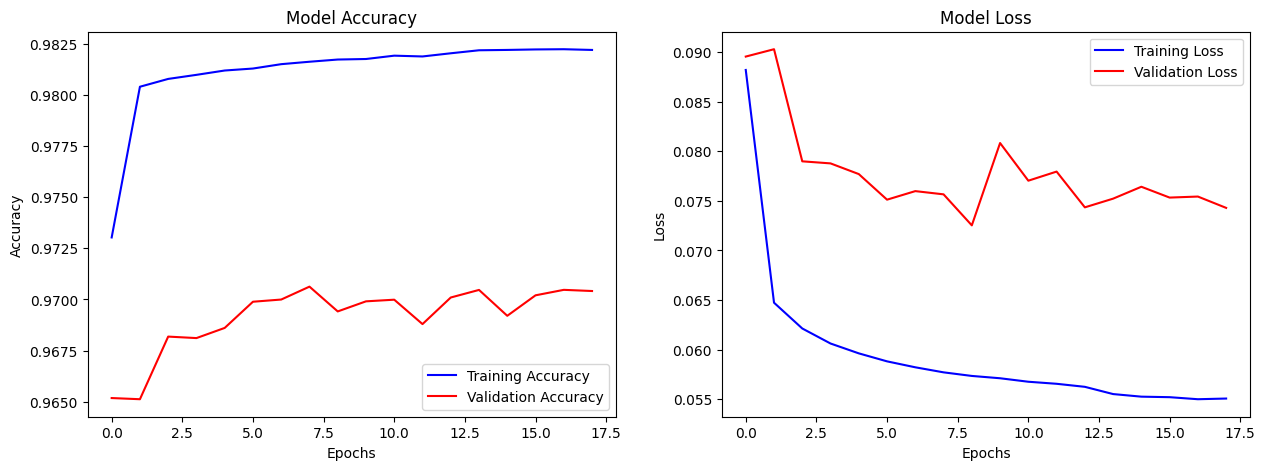

In [70]:
# Ploting model accuracy and loss

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig(os.path.join(model_accuracy_loss_path, 'model_accuracy_loss.png'))

print(f'The model accuracy and loss has been saved successfullyat {model_accuracy_loss_path}')

plt.show()

In [80]:
# Creating the folder to save the confusion matrix in info folder

confusion_matrix_folder = 'confusion_matrix'

confusion_matrix_path = os.path.join(dir, confusion_matrix_folder)

if not os.path.exists(confusion_matrix_path):
    os.makedirs(confusion_matrix_path)
    print(f"Directory {confusion_matrix_path} created ")

Directory info\confusion_matrix created 


8179/8179 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
The confusion matrix has been saved successfully at info\confusion_matrix


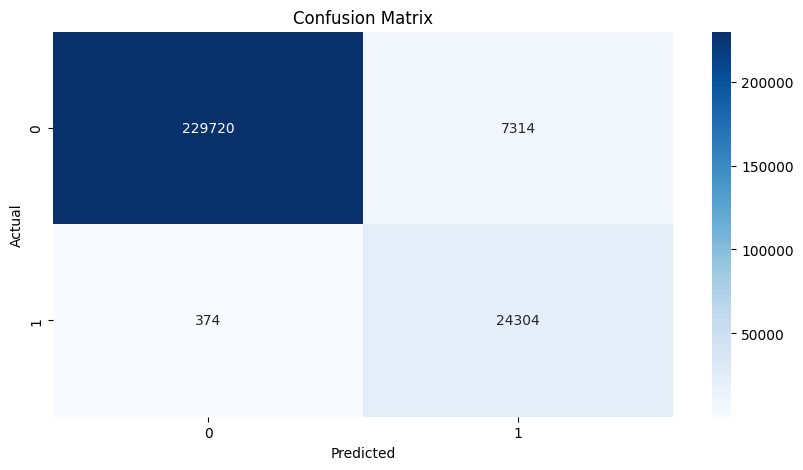

In [81]:
# Predicting the target variable
Y_pred = model.predict(X_test)

Y_pred = np.argmax(Y_pred, axis=1)

Y_test = np.argmax(Y_test, axis=1)

# Creating a confusion matrix

cm = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.savefig(os.path.join(confusion_matrix_path, 'confusion_matrix.png'))

print(f'The confusion matrix has been saved successfully at {confusion_matrix_path}')

plt.show()
